In [1]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Flatten
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

# Data Preprocessing

### Downloading  Data

In [2]:
!wget https://scholar.cu.edu.eg/Dataset_BUSI.zip --no-check-certificate 

--2022-03-17 20:35:15--  https://scholar.cu.edu.eg/Dataset_BUSI.zip
Resolving scholar.cu.edu.eg (scholar.cu.edu.eg)... 195.246.42.194
Connecting to scholar.cu.edu.eg (scholar.cu.edu.eg)|195.246.42.194|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 205873341 (196M) [application/zip]
Saving to: ‘Dataset_BUSI.zip’

Dataset_BUSI.zip    100%[===================>] 196.34M   381KB/s    in 8m 55s  

2022-03-17 20:44:11 (376 KB/s) - ‘Dataset_BUSI.zip’ saved [205873341/205873341]



In [3]:
!unzip /content/Dataset_BUSI.zip

Archive:  /content/Dataset_BUSI.zip
   creating: Dataset_BUSI_with_GT/
   creating: Dataset_BUSI_with_GT/benign/
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dat

### Data Augmantation

input:
*   data path list [[path ,label ], [],]
*   nof imgs to generate 
*   category to generate from


it appends those images to the list

In [4]:
def DataAug(data: list , nof_imgs : int ):
  def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result
  sample_imgs_labels = [i for i in data[:nof_imgs]]
  for i in range(nof_imgs):

    img = cv2.flip( cv2.imread( sample_imgs_labels[i][0] )  , 1)
    img = rotate_image( img , random.randint(30,120))

    fle_name = sample_imgs_labels[i][0].split('/')[:-1] +['aug_'+ sample_imgs_labels[i][0].split('/')[-1] ]
    fle_name ='/'.join( fle_name)
    cv2.imwrite(fle_name  , img )
    data.append([fle_name,sample_imgs_labels[i][1] ])
    random.shuffle(data)
  return data

In [5]:
imgs=[['/content/Dataset_BUSI_with_GT/normal/normal (99).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (52).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (26).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (118).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (12).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (38).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (11).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (126).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (13).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (83).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (88).png', 'normal'] ]
data = DataAug(data= imgs , nof_imgs = 4)
print (data)

[['/content/Dataset_BUSI_with_GT/normal/aug_normal (26).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/aug_normal (118).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (38).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (13).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (126).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (26).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (11).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (88).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (12).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/aug_normal (52).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (118).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (83).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/normal (99).png', 'normal'], ['/content/Dataset_BUSI_with_GT/normal/aug_normal (99).png', 'normal'], ['/content/Dataset_BUSI_with

### Images Path Dictionary

Steps to split the dataset into training,validation,test sets: 

Inputs:
*   data directory 
*   split percentage 

Output:
*   Dictionary { keys -> train + validate + test , values ->  list [ image path' , tag ] }








In [6]:
def GetDataDictionary(d_path:str,tr_s:float):
  v_s = float((1-tr_s)/2)
  data_dict = {'tr':[],'val':[],'ts':[]}
  for dir in os.listdir(d_path) :
    files = [[d_path+'/'+dir+'/'+fle , dir] for fle in os.listdir(d_path+'/'+dir)  if 'mask' not in fle] #["path",ground truth]
    # if aug
    if (dir == 'normal') : 
      files = DataAug(data = files , nof_imgs = int(len(files)/2) )
    if (dir == 'malignant') : 
      files = DataAug(data = files , nof_imgs = int(len(files)/2) )
    if (dir == 'benign') : 
      files = DataAug(data = files , nof_imgs = int(len(files)/2) )
    
    tr, val , ts = np.split(files, [int(len(files)*tr_s), int(len(files)*(1-v_s)) ])
    data_dict['tr'].extend(tr)
    data_dict['val'].extend(val)
    data_dict['ts'].extend(ts)
  random.shuffle(data_dict['tr'] )
  random.shuffle(data_dict['val'])
  random.shuffle(data_dict['ts'] )
  return data_dict

In [7]:
path ='/content/Dataset_BUSI_with_GT'
data_dict =dict()
data_dict= GetDataDictionary(d_path = path,tr_s = 0.8)
print ( len(  [ l[0] for l in data_dict['val'] if 'normal'  in l[0] ]   ) ) 
print ( len(  [ l[0] for l in data_dict['val'] if 'malignant'  in l[0] ]   ) ) 
print ( len(  [ l[0] for l in data_dict['val'] if 'benign'  in l[0] ]   ) ) 


20
31
65


### Data Pipelining

Pipeline Class :
return normalized image



In [31]:
class pipeline(tf.keras.utils.Sequence):
  def __init__(self,input_x,labels,resize_shape,batch_size,shuffle=True):
    self.x = input_x  # pipeline input 
    self.y = labels   # pipeline output
    self.resize_shape = resize_shape
    # The pipeline needs to take ''' batch size ( 8 examples , 16 examples, 32 example, 48 example)
    # and shuffle paremeter [ true - false ] to shuffle or not shuffle the data
    self.batch_size = batch_size  
    self.shuffle    = shuffle 
    self.on_epoch_end()

  def __len__(self):
    # This function determines the number of batches
    return int(np.floor(len(self.y) / self.batch_size))

  def __getitem__(self, index):
    # Get the current batch 
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__get_batch(indexes)
    return X,y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.x))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __read_image(self,path):
    ''' a function that reads the image and do resizing changes the color convention'''
    img=cv2.imread(path)
    dim = self.resize_shape[0:2]
    #for interpolation in enlarging: cv2.INTER_LANCZOS4 : reducing: cv2.INTER_AREA  
    interpolation = cv2.INTER_AREA if((self.resize_shape[0]*self.resize_shape[1])<=(img.shape[0]*img.shape[1])) else cv2.INTER_LANCZOS4
    if (img.shape[2]!=3):
      img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    return(cv2.resize(img,dim,interpolation =interpolation))/255.0
    

  def __get_label(self,label_string):
    ''' a function that converts string to the class number '''
    if (label_string == 'normal'):
      return [1,0,0]
    elif (label_string == 'malignant'):
      return [0,1,0]
    elif (label_string == 'benign'):
      return [0,0,1] 



  def __get_batch(self, list_IDs_temp):
    '''
    Does the following three main things:
    1- Create two arrays for input and output with correct shapes
    '''
    X = np.empty((self.batch_size, *self.resize_shape),dtype=np.float32)
    y = np.empty((self.batch_size, 3))

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Get expression
      X[i,:,:] = self.__read_image(self.x[ID])

      # store label
      y[i,]    = self.__get_label(self.y[ID])

    return X, y

#### Build pipeline

In [32]:
train_x= np.array( np.array( data_dict['tr' ] ) [:,0] )
train_y= np.array( np.array( data_dict['tr' ] ) [:,1] )
test_x = np.array( np.array( data_dict['ts' ] ) [:,0] )
test_y = np.array( np.array( data_dict['ts' ] ) [:,1] )
val_x  = np.array( np.array( data_dict['val'] ) [:,0] )
val_y  = np.array( np.array( data_dict['val'] ) [:,1] )

In [69]:
resize_shape= (32,32,3)
batch_size = 16
epochs     = 40

train_generator = pipeline(input_x=train_x,labels = train_y
                           ,resize_shape = resize_shape ,batch_size=batch_size)

validation_generator = pipeline(input_x = val_x , labels = val_y
                           ,resize_shape = resize_shape ,batch_size=batch_size)

test_generator = pipeline(input_x = test_x , labels = test_y
                           ,resize_shape = resize_shape ,batch_size=batch_size)

# Model 

### Model Abstract

steps to creat the model abs
*   INPUTS: 
  *   images shape ( , , )
  *   nof  filter in each CNN layer
  *   nof nodes in last dense layer
*   Create the convolutional base

*   Hidden layers:
  *    3 CNN 
  *   2 dense 

*   OUTPUT layer: 3 nodes
*   returns : model as an obj



In [70]:
def CNNModel(n_fltr:int ,n_nds_dns: int, shape):
  #convolutional base (feature extraction)
  cnn_model = models.Sequential()
  cnn_model.add(layers.Conv2D(n_fltr, (3, 3), activation='relu', input_shape= shape ) )
  cnn_model.add(layers.MaxPooling2D((2, 2)))
  cnn_model.add(layers.BatchNormalization(axis=-1))
  cnn_model.add(layers.Conv2D(n_fltr*2, (3, 3), activation='relu'))
  cnn_model.add(layers.MaxPooling2D((2, 2)))
  cnn_model.add(layers.BatchNormalization(axis=-1))
  # cnn_model.add(layers.Conv2D(n_fltr, (3, 3), activation='relu'))
  # cnn_model.add(layers.BatchNormalization(axis=-1))
  #fully-connected layer 
  cnn_model.add(layers.Flatten())
  cnn_model.add(layers.Dense(n_nds_dns, activation='relu'))
  cnn_model.add(Dropout(0.5))
  cnn_model.add(layers.Dense((n_nds_dns/2), activation='relu'))
  cnn_model.add(Dropout(0.5))
  # ouput layer
  cnn_model.add(layers.Dense(3, activation='softmax'))
  #Compile and train the model
  cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return cnn_model


In [71]:
model = CNNModel(n_fltr = 8 ,n_nds_dns = 64, shape = resize_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 8)         224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 15, 15, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 16)        1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                      


### Model Training

In [72]:
checkpoint_path = "training/training.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(x=train_generator,validation_data=validation_generator,epochs=epochs)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


58/58 [==============================] - 12s 192ms/step - loss: 1.2814 - accuracy: 0.4655 - val_loss: 1.0633 - val_accuracy: 0.5536
Epoch 2/40
58/58 [==============================] - 11s 185ms/step - loss: 1.0830 - accuracy: 0.5151 - val_loss: 1.0645 - val_accuracy: 0.5357
Epoch 3/40
58/58 [==============================] - 11s 188ms/step - loss: 1.0225 - accuracy: 0.5356 - val_loss: 1.0697 - val_accuracy: 0.4911
Epoch 4/40
58/58 [==============================] - 11s 188ms/step - loss: 0.9234 - accuracy: 0.5765 - val_loss: 1.0702 - val_accuracy: 0.4464
Epoch 5/40
58/58 [==============================] - 11s 190ms/step - loss: 0.9247 - accuracy: 0.5776 - val_loss: 1.0470 - val_accuracy: 0.4732
Epoch 6/40
58/58 [==============================] - 11s 189ms/step - loss: 0.8574 - accuracy: 0.5970 - val_loss: 1.0337 - val_accuracy: 0.5357
Epoch 7/40
58/58 [==============================] - 11s 189ms/step - loss: 0.8356 - accuracy: 0.6121 - val_loss: 0.9298 - val_accuracy: 0.5714
Epoch 8/40

In [73]:
#Save Model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Model Accuracy

### Accuracy

input :
*   test imge pathes 
*   ground truth labels
*   sample size we want to show



In [74]:
# cv2_imshow(cv2.imread(test_x[0]))
def TestSample(img_pths:list,img_shape=resize_shape,size: int = 8 ):
  yhat =list()
  sample_paths = random.choices(img_pths, k=size)
  # /content/Dataset_BUSI_with_GT/normal/normal (1).png
  sample_GT = [i.split('/')[3] for i in sample_paths]
  sample_imgs  = np.empty(shape=(size,*img_shape))
  for i in range(size):
    sample_imgs[i,:] = cv2.resize( cv2.imread(img_pths[i]) , img_shape[0:2]) /255.0 #normalization
    y = model.predict(sample_imgs[i][np.newaxis,:])[0]
    if  ( y[0]> y[1] and y[0]> y[2] ): yhat.append('normal')
    elif( y[1]> y[0] and y[1]> y[2] ): yhat.append('malignant')
    elif( y[2]> y[0] and y[2]> y[1] ): yhat.append('benign')
  return sample_imgs , yhat , sample_GT

In [75]:
test_sample , yhat, sample_GT= TestSample(test_x,size=len(test_x))


In [76]:
print (len(sample_GT))
print (len(test_sample))
print (len(yhat))

119
119
119


In [77]:
def ModelAurrecy(gt:list , yhat: list ):
  positive = 0
  for i in range (len(gt)):
    if(gt[i]==yhat[i]): positive += 1
  return positive / len(gt) * 100

In [78]:
ModelAurrecy(sample_GT,yhat)

60.50420168067227

### Test Sample

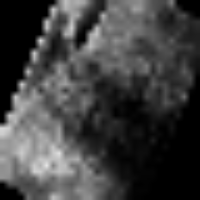

prediction of the model is benign
groung_truth of the image is benign
***********************************************************


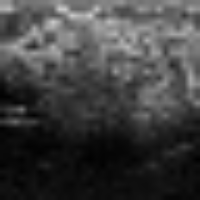

prediction of the model is benign
groung_truth of the image is normal
***********************************************************


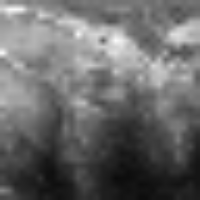

prediction of the model is malignant
groung_truth of the image is malignant
***********************************************************


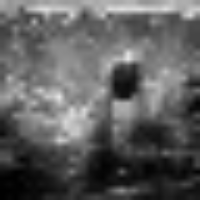

prediction of the model is benign
groung_truth of the image is benign
***********************************************************


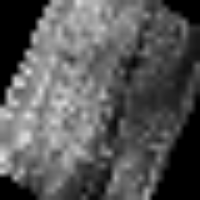

prediction of the model is benign
groung_truth of the image is normal
***********************************************************


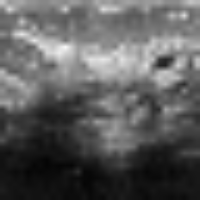

prediction of the model is benign
groung_truth of the image is benign
***********************************************************


In [79]:
for i in range(6):
  cv2_imshow( cv2.resize(test_sample[i]*255, (200,200) ))
  print ("prediction of the model is "+ yhat[i])
  print ("groung_truth of the image is "+ sample_GT[i])
  print("***********************************************************")